# Scraping Jumia Ecommerce Site: DSE HACKATHON

## Import libraries

In [244]:
import requests as req
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np

import time

import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
import re

## Define function to fetch website html data

In [245]:
def fetch_html_data(web_address):
    try:
        # print(f"\nFetching data from {web_address}...")
        res = req.get(web_address)
        return res
    except req.exceptions.RequestException as e:
        print('Stopped:', e)
    except TypeError as e:
        print('Stopped:', e)

# Define function to convert html data to BeautifulSoup object 

In [246]:
def convert_web_data_to_beautiful_soup_obj(web_data):
    try:
        # print("Creating BeautifulSoup object...")
        soup_obj = BeautifulSoup(web_data.text, "html.parser")
        # print("Success! Object created!")
        return soup_obj
    except Exception as e:
        print("Stopped:", e)

### Create array of products on each page, add each to product dictionary & append to array iteratively

In [247]:
all_products_list = []

def append_one_product_details_dictionary_to_list(page):
    # print(f"Appending page {page} products' details to array")
    
    page_products_details_soup = soup.find_all("article", class_="prd _fb col c-prd")
    
    for detail in page_products_details_soup:
        details_dict = {"name": detail.find("h3", class_="name").text.strip(),
                        "new_price": detail.find("div", class_="prc").text.strip(),
                        "old_price": detail.find("div", class_="old").text.strip() if detail.find("div", class_="old") else None,
                        "discount": detail.find("div", class_="bdg _dsct _sm").text.strip() if detail.find("div", class_="bdg _dsct _sm") else None,
                        "rating": detail.find("div", class_="stars _s").text.strip() if detail.find("div", class_="stars _s") else None,
                        "votes": detail.find("div", class_="rev").text.strip() if detail.find("div", class_="rev") else None}
        all_products_list.append(details_dict)


# len(product_details_clean)

### Declare the products' url & the total webpage count

In [248]:
other_pages_url = "https://www.jumia.co.ke/all-products/?page="
webpage_num_total = 50

### Fetch webdata, convert to BeautifulSoup Object, add product details dictionary to list

In [249]:
for page in range(1, webpage_num_total+1, 1):
    other_pages_url = "https://www.jumia.co.ke/all-products/?page="
    page = str(page)
    other_pages_url = other_pages_url + page
    response = fetch_html_data(other_pages_url)
    # time.sleep(2.5)
    soup = convert_web_data_to_beautiful_soup_obj(response)
    append_one_product_details_dictionary_to_list(page)
# all_products_list

### Check product count

In [250]:
len(all_products_list)

2000

### Convert products list to pandas dataframe

In [251]:
products_df = pd.DataFrame(all_products_list)
products_df.head()

,name,new_price,old_price,discount,rating,votes
0,NIVEA Perfect & Radiant Even Tone Day And Nigh...,KSh 899,"KSh 1,560",42%,4.5 out of 5,4.5 out of 5(2218)
1,NIVEA Radiant & Beauty Advanced Care Lotion Fo...,KSh 854,"KSh 1,460",42%,4.7 out of 5,4.7 out of 5(612)
2,NIVEA Nourishing Cocoa Body Lotion With Cocoa ...,"KSh 1,174","KSh 1,302",10%,4.7 out of 5,4.7 out of 5(1119)
3,"NIVEA Pearl & Beauty Anti-Perspirant Rollon, 4...",KSh 728,"KSh 1,040",30%,4.6 out of 5,4.6 out of 5(830)
4,NIVEA MEN Deep Antibacterial Anti-Perspirant R...,KSh 655,"KSh 1,040",37%,4.6 out of 5,4.6 out of 5(621)


In [252]:
products_df.shape

(2000, 6)

# Data Cleaning Section

### Clean new_price column

In [253]:
# Remove currency name 'Ksh' & convert values to float
def remove_currency_name_in_new_price(val):
    val = val.split(' ')[1]
    return val
products_df['new_price'] = products_df['new_price'].apply(remove_currency_name_in_new_price)

In [254]:
print(type(products_df['new_price'][1]))
print(products_df['new_price'].head())

<class 'str'>
0      899
1      854
2    1,174
3      728
4      655
Name: new_price, dtype: object


In [255]:
# Remove comma from thousands price values
products_df['new_price'] = products_df['new_price'].apply(lambda x: x.replace(',','') if ',' in x else x)
products_df['new_price'].head()

0     899
1     854
2    1174
3     728
4     655
Name: new_price, dtype: object

In [256]:
print(type(products_df['new_price'][1]))

<class 'str'>


In [257]:
# Convert new_price column to float
products_df['new_price'] = products_df['new_price'].apply(lambda x: float(x))

In [258]:
print(type(products_df['new_price'][1]))

<class 'numpy.float64'>


In [259]:
products_df.head()

,name,new_price,old_price,discount,rating,votes
0,NIVEA Perfect & Radiant Even Tone Day And Nigh...,899.0,"KSh 1,560",42%,4.5 out of 5,4.5 out of 5(2218)
1,NIVEA Radiant & Beauty Advanced Care Lotion Fo...,854.0,"KSh 1,460",42%,4.7 out of 5,4.7 out of 5(612)
2,NIVEA Nourishing Cocoa Body Lotion With Cocoa ...,1174.0,"KSh 1,302",10%,4.7 out of 5,4.7 out of 5(1119)
3,"NIVEA Pearl & Beauty Anti-Perspirant Rollon, 4...",728.0,"KSh 1,040",30%,4.6 out of 5,4.6 out of 5(830)
4,NIVEA MEN Deep Antibacterial Anti-Perspirant R...,655.0,"KSh 1,040",37%,4.6 out of 5,4.6 out of 5(621)


### Clean old_price column

In [260]:
# Use [:10] notation to print the first 10 values
products_df['old_price'].unique()[:10]

array(['KSh 1,560', 'KSh 1,460', 'KSh 1,302', 'KSh 1,040', 'KSh 5,610',
       'KSh 780', 'KSh 39,999', 'KSh 3,840', 'KSh 1,099', 'KSh 15,995'],
      dtype=object)

In [261]:
# Remove currency name 'Ksh'
products_df['old_price'] = products_df['old_price'].apply(lambda x: x.split(' ')[1] if x is not None else x)
products_df['old_price'].head()

0    1,560
1    1,460
2    1,302
3    1,040
4    1,040
Name: old_price, dtype: object

In [262]:
# Remove commas from values
products_df['old_price'] = products_df['old_price'].apply(lambda x: x.replace(',','') if x is not None else x)
products_df['old_price'].head(10)

0     1560
1     1460
2     1302
3     1040
4     1040
5     1040
6     5610
7      780
8    39999
9     3840
Name: old_price, dtype: object

In [263]:
# Convert the string values into floats
products_df['old_price'] = products_df['old_price'].apply(lambda x: float(x) if x is not None else x)
products_df['old_price'].head(10)

0     1560.0
1     1460.0
2     1302.0
3     1040.0
4     1040.0
5     1040.0
6     5610.0
7      780.0
8    39999.0
9     3840.0
Name: old_price, dtype: float64

In [264]:
products_df['old_price']

0       1560.0
1       1460.0
2       1302.0
3       1040.0
4       1040.0
         ...  
1995       NaN
1996     949.0
1997    1799.0
1998     185.0
1999     700.0
Name: old_price, Length: 2000, dtype: float64

In [265]:
# Index 18 from above was null. So checking its type: 
type(products_df['old_price'][18])

numpy.float64

In [266]:
products_df.head(20)

,name,new_price,old_price,discount,rating,votes
0,NIVEA Perfect & Radiant Even Tone Day And Nigh...,899.0,1560.0,42%,4.5 out of 5,4.5 out of 5(2218)
1,NIVEA Radiant & Beauty Advanced Care Lotion Fo...,854.0,1460.0,42%,4.7 out of 5,4.7 out of 5(612)
2,NIVEA Nourishing Cocoa Body Lotion With Cocoa ...,1174.0,1302.0,10%,4.7 out of 5,4.7 out of 5(1119)
3,"NIVEA Pearl & Beauty Anti-Perspirant Rollon, 4...",728.0,1040.0,30%,4.6 out of 5,4.6 out of 5(830)
4,NIVEA MEN Deep Antibacterial Anti-Perspirant R...,655.0,1040.0,37%,4.6 out of 5,4.6 out of 5(621)
5,NIVEA Pearl & Beauty Black Pearl Fine Fragranc...,728.0,1040.0,30%,4.7 out of 5,4.7 out of 5(219)
6,NIVEA Perfect & Radiant Luminous630 Anti Dark ...,3647.0,5610.0,35%,4.4 out of 5,4.4 out of 5(352)
7,NIVEA Perfect & Radiant Even Tone Day Cream SP...,585.0,780.0,25%,4.4 out of 5,4.4 out of 5(560)
8,"TCL 43S5400 S Series, 43"" Full HD Smart TV - B...",33245.0,39999.0,17%,4.6 out of 5,4.6 out of 5(43)
9,NIVEA Q10 Power Anti-Wrinkle Day Cream 50ml & ...,2246.0,3840.0,42%,4.6 out of 5,4.6 out of 5(416)


### Cleaning 'discount' column

In [267]:
# Check unique values if any
products_df['discount'].unique()

array(['42%', '10%', '30%', '37%', '35%', '25%', '17%', '27%', '18%',
       '14%', '4%', '31%', '43%', '8%', '11%', '9%', '20%', None, '12%',
       '34%', '33%', '29%', '13%', '28%', '46%', '26%', '3%', '21%',
       '41%', '19%', '40%', '15%', '38%', '36%', '50%', '49%', '48%',
       '5%', '32%', '16%', '39%', '45%', '55%', '24%', '79%', '6%', '44%',
       '7%', '47%', '23%', '51%', '58%', '1%', '22%', '2%', '53%', '70%',
       '59%', '56%'], dtype=object)

In [268]:
# Remove the percent sign
products_df['discount'] = products_df['discount'].apply(lambda x: x.replace('%','') if x is not None else x)
products_df['discount'].unique()

array(['42', '10', '30', '37', '35', '25', '17', '27', '18', '14', '4',
       '31', '43', '8', '11', '9', '20', None, '12', '34', '33', '29',
       '13', '28', '46', '26', '3', '21', '41', '19', '40', '15', '38',
       '36', '50', '49', '48', '5', '32', '16', '39', '45', '55', '24',
       '79', '6', '44', '7', '47', '23', '51', '58', '1', '22', '2', '53',
       '70', '59', '56'], dtype=object)

In [269]:
# Convert values into float & divide by 100 to represent the percentages as decimal values
products_df['discount'] = products_df['discount'].apply(lambda x: float(x)/100 if x is not None else x)
products_df['discount'].unique()  # A numbers now floats and None replaced with NaN

array([0.42, 0.1 , 0.3 , 0.37, 0.35, 0.25, 0.17, 0.27, 0.18, 0.14, 0.04,
       0.31, 0.43, 0.08, 0.11, 0.09, 0.2 ,  nan, 0.12, 0.34, 0.33, 0.29,
       0.13, 0.28, 0.46, 0.26, 0.03, 0.21, 0.41, 0.19, 0.4 , 0.15, 0.38,
       0.36, 0.5 , 0.49, 0.48, 0.05, 0.32, 0.16, 0.39, 0.45, 0.55, 0.24,
       0.79, 0.06, 0.44, 0.07, 0.47, 0.23, 0.51, 0.58, 0.01, 0.22, 0.02,
       0.53, 0.7 , 0.59, 0.56])

In [270]:
# Check head once more
products_df.head()

,name,new_price,old_price,discount,rating,votes
0,NIVEA Perfect & Radiant Even Tone Day And Nigh...,899.0,1560.0,0.42,4.5 out of 5,4.5 out of 5(2218)
1,NIVEA Radiant & Beauty Advanced Care Lotion Fo...,854.0,1460.0,0.42,4.7 out of 5,4.7 out of 5(612)
2,NIVEA Nourishing Cocoa Body Lotion With Cocoa ...,1174.0,1302.0,0.10,4.7 out of 5,4.7 out of 5(1119)
3,"NIVEA Pearl & Beauty Anti-Perspirant Rollon, 4...",728.0,1040.0,0.30,4.6 out of 5,4.6 out of 5(830)
4,NIVEA MEN Deep Antibacterial Anti-Perspirant R...,655.0,1040.0,0.37,4.6 out of 5,4.6 out of 5(621)


### Cleaning the rating column

In [271]:
# Check for unique values first
products_df['rating'].unique()

array(['4.5 out of 5', '4.7 out of 5', '4.6 out of 5', '4.4 out of 5',
       '4.3 out of 5', '4 out of 5', '3.3 out of 5', '4.2 out of 5',
       '4.1 out of 5', '4.9 out of 5', '3.6 out of 5', '5 out of 5',
       '3.7 out of 5', None, '4.8 out of 5', '3 out of 5', '3.5 out of 5',
       '3.9 out of 5', '3.8 out of 5', '2 out of 5', '3.4 out of 5',
       '1 out of 5', '1.7 out of 5', '2.3 out of 5', '2.5 out of 5',
       '3.1 out of 5', '1.5 out of 5', '3.2 out of 5', '2.8 out of 5',
       '2.7 out of 5'], dtype=object)

In [272]:
# Split rating string values into 4 elements and select the first element unless its None(left as is)
products_df['rating'] = products_df['rating'].apply(lambda x: x.split(' ')[0] if x is not None else x)
products_df['rating'].unique()

array(['4.5', '4.7', '4.6', '4.4', '4.3', '4', '3.3', '4.2', '4.1', '4.9',
       '3.6', '5', '3.7', None, '4.8', '3', '3.5', '3.9', '3.8', '2',
       '3.4', '1', '1.7', '2.3', '2.5', '3.1', '1.5', '3.2', '2.8', '2.7'],
      dtype=object)

In [273]:
# Convert the values into float
products_df['rating'] = products_df['rating'].apply(lambda x: float(x) if x is not None else x)
type(products_df['rating'][1])

numpy.float64

In [274]:
products_df.head(20)

,name,new_price,old_price,discount,rating,votes
0,NIVEA Perfect & Radiant Even Tone Day And Nigh...,899.0,1560.0,0.42,4.5,4.5 out of 5(2218)
1,NIVEA Radiant & Beauty Advanced Care Lotion Fo...,854.0,1460.0,0.42,4.7,4.7 out of 5(612)
2,NIVEA Nourishing Cocoa Body Lotion With Cocoa ...,1174.0,1302.0,0.10,4.7,4.7 out of 5(1119)
3,"NIVEA Pearl & Beauty Anti-Perspirant Rollon, 4...",728.0,1040.0,0.30,4.6,4.6 out of 5(830)
4,NIVEA MEN Deep Antibacterial Anti-Perspirant R...,655.0,1040.0,0.37,4.6,4.6 out of 5(621)
5,NIVEA Pearl & Beauty Black Pearl Fine Fragranc...,728.0,1040.0,0.30,4.7,4.7 out of 5(219)
6,NIVEA Perfect & Radiant Luminous630 Anti Dark ...,3647.0,5610.0,0.35,4.4,4.4 out of 5(352)
7,NIVEA Perfect & Radiant Even Tone Day Cream SP...,585.0,780.0,0.25,4.4,4.4 out of 5(560)
8,"TCL 43S5400 S Series, 43"" Full HD Smart TV - B...",33245.0,39999.0,0.17,4.6,4.6 out of 5(43)
9,NIVEA Q10 Power Anti-Wrinkle Day Cream 50ml & ...,2246.0,3840.0,0.42,4.6,4.6 out of 5(416)


### Cleaning the 'votes' column

In [275]:
# Explore unique values
products_df['votes'].unique()[:10]

array(['4.5 out of 5(2218)', '4.7 out of 5(612)', '4.7 out of 5(1119)',
       '4.6 out of 5(830)', '4.6 out of 5(621)', '4.7 out of 5(219)',
       '4.4 out of 5(352)', '4.4 out of 5(560)', '4.6 out of 5(43)',
       '4.6 out of 5(416)'], dtype=object)

In [276]:
# Extract the votes count with string manipulation methods & convert values to integer values
products_df['votes'] = products_df['votes'].apply(lambda x: float(x.split('(')[1].split(')')[0]) if x is not None else x)
products_df['votes'].unique()

array([2.218e+03, 6.120e+02, 1.119e+03, 8.300e+02, 6.210e+02, 2.190e+02,
       3.520e+02, 5.600e+02, 4.300e+01, 4.160e+02, 6.400e+01, 3.610e+02,
       7.200e+01, 6.700e+01, 2.500e+01, 1.600e+01, 4.000e+01, 2.600e+01,
       1.500e+01, 7.000e+00, 4.100e+01, 9.000e+00, 2.700e+01, 5.000e+00,
       2.000e+00, 1.000e+00, 6.000e+00, 1.000e+01,       nan, 3.000e+00,
       2.800e+01, 1.400e+01, 6.900e+01, 2.200e+01, 2.100e+01, 1.700e+01,
       8.000e+00, 4.000e+00, 2.300e+01, 4.800e+01, 6.100e+01, 5.300e+01,
       3.700e+01, 1.800e+01, 1.200e+01, 4.430e+02, 1.000e+02, 9.000e+01,
       4.590e+02, 1.428e+03, 1.104e+03, 2.170e+02, 7.100e+01, 1.495e+03,
       3.530e+02, 3.980e+02, 1.120e+03, 1.888e+03, 6.750e+02, 8.900e+01,
       6.570e+02, 5.900e+01, 2.770e+02, 2.820e+02, 3.200e+02, 1.503e+03,
       1.650e+02, 1.710e+02, 7.740e+02, 1.520e+02, 4.820e+02, 2.011e+03,
       3.480e+02, 1.550e+02, 7.300e+02, 2.630e+02, 5.440e+02, 4.910e+02,
       8.400e+02, 9.900e+01, 5.710e+02, 4.490e+02, 

In [277]:
products_df.head(20)

,name,new_price,old_price,discount,rating,votes
0,NIVEA Perfect & Radiant Even Tone Day And Nigh...,899.0,1560.0,0.42,4.5,2218.0
1,NIVEA Radiant & Beauty Advanced Care Lotion Fo...,854.0,1460.0,0.42,4.7,612.0
2,NIVEA Nourishing Cocoa Body Lotion With Cocoa ...,1174.0,1302.0,0.10,4.7,1119.0
3,"NIVEA Pearl & Beauty Anti-Perspirant Rollon, 4...",728.0,1040.0,0.30,4.6,830.0
4,NIVEA MEN Deep Antibacterial Anti-Perspirant R...,655.0,1040.0,0.37,4.6,621.0
5,NIVEA Pearl & Beauty Black Pearl Fine Fragranc...,728.0,1040.0,0.30,4.7,219.0
6,NIVEA Perfect & Radiant Luminous630 Anti Dark ...,3647.0,5610.0,0.35,4.4,352.0
7,NIVEA Perfect & Radiant Even Tone Day Cream SP...,585.0,780.0,0.25,4.4,560.0
8,"TCL 43S5400 S Series, 43"" Full HD Smart TV - B...",33245.0,39999.0,0.17,4.6,43.0
9,NIVEA Q10 Power Anti-Wrinkle Day Cream 50ml & ...,2246.0,3840.0,0.42,4.6,416.0


## Dealing with null values

In [278]:
products_df.isnull().sum().idxmax()

'old_price'

In [279]:
print(f"new_price nulls: {products_df.new_price.isnull().sum()}")
print(f"old_price nulls: {products_df.old_price.isnull().sum()}")
print(f"discount nulls: {products_df.discount.isnull().sum()}")
print(f"rating nulls: {products_df.rating.isnull().sum()}")
print(f"votes nulls: {products_df.votes.isnull().sum()}")

new_price nulls: 0
old_price nulls: 301
discount nulls: 301
rating nulls: 199
votes nulls: 199


### Fill null values in discount column 

In [280]:
# Use discount column average to fill nulls
products_df['discount'] = products_df['discount'].fillna(round(products_df['discount'].mean(), 2))
products_df.discount.isnull().sum()

0

### Fill null values in old_price based on the discount column average

In [281]:
def multiply_fill_old_price_column_nulls(row):
    new_price = row['new_price']
    discount_column_mean = round(products_df['discount'].mean(), 2)
    discount_multiplier = 1 - discount_column_mean
    
    if not pd.isna(row['old_price']):
        return row['old_price']
    return new_price * discount_column_mean
        
products_df['old_price'] = products_df.apply(multiply_fill_old_price_column_nulls, axis=1)
products_df.old_price.isnull().sum()

0

### Fill rating nulls with column mean

In [282]:
products_df['rating'] = products_df['rating'].fillna(round(products_df['rating'].mean(), 2))
products_df.rating.isnull().sum()

0

### Fill votes nulls with column mean

In [283]:
products_df['votes'] = products_df['votes'].fillna(round(products_df['votes'].mean(), 2))
products_df.votes.isnull().sum()

0

## Rechecking nulls for all columns again

In [284]:
print(f"new_price nulls: {products_df.new_price.isnull().sum()}")
print(f"old_price nulls: {products_df.old_price.isnull().sum()}")
print(f"discount nulls: {products_df.discount.isnull().sum()}")
print(f"rating nulls: {products_df.rating.isnull().sum()}")
print(f"votes nulls: {products_df.votes.isnull().sum()}")

new_price nulls: 0
old_price nulls: 0
discount nulls: 0
rating nulls: 0
votes nulls: 0


In [285]:
products_df.head(10)

,name,new_price,old_price,discount,rating,votes
0,NIVEA Perfect & Radiant Even Tone Day And Nigh...,899.0,1560.0,0.42,4.5,2218.0
1,NIVEA Radiant & Beauty Advanced Care Lotion Fo...,854.0,1460.0,0.42,4.7,612.0
2,NIVEA Nourishing Cocoa Body Lotion With Cocoa ...,1174.0,1302.0,0.10,4.7,1119.0
3,"NIVEA Pearl & Beauty Anti-Perspirant Rollon, 4...",728.0,1040.0,0.30,4.6,830.0
4,NIVEA MEN Deep Antibacterial Anti-Perspirant R...,655.0,1040.0,0.37,4.6,621.0
5,NIVEA Pearl & Beauty Black Pearl Fine Fragranc...,728.0,1040.0,0.30,4.7,219.0
6,NIVEA Perfect & Radiant Luminous630 Anti Dark ...,3647.0,5610.0,0.35,4.4,352.0
7,NIVEA Perfect & Radiant Even Tone Day Cream SP...,585.0,780.0,0.25,4.4,560.0
8,"TCL 43S5400 S Series, 43"" Full HD Smart TV - B...",33245.0,39999.0,0.17,4.6,43.0
9,NIVEA Q10 Power Anti-Wrinkle Day Cream 50ml & ...,2246.0,3840.0,0.42,4.6,416.0


In [286]:
products_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   name       2000 non-null   object 
 1   new_price  2000 non-null   float64
 2   old_price  2000 non-null   float64
 3   discount   2000 non-null   float64
 4   rating     2000 non-null   float64
 5   votes      2000 non-null   float64
dtypes: float64(5), object(1)
memory usage: 93.9+ KB


### Assign cleaned dataframe to a new name

In [287]:
products_clean_df = products_df
products_clean_df

,name,new_price,old_price,discount,rating,votes
0,NIVEA Perfect & Radiant Even Tone Day And Nigh...,899.0,1560.0,0.42,4.5,2218.0
1,NIVEA Radiant & Beauty Advanced Care Lotion Fo...,854.0,1460.0,0.42,4.7,612.0
2,NIVEA Nourishing Cocoa Body Lotion With Cocoa ...,1174.0,1302.0,0.10,4.7,1119.0
3,"NIVEA Pearl & Beauty Anti-Perspirant Rollon, 4...",728.0,1040.0,0.30,4.6,830.0
4,NIVEA MEN Deep Antibacterial Anti-Perspirant R...,655.0,1040.0,0.37,4.6,621.0
...,...,...,...,...,...,...
1995,Cotton Recieving Blankets,1500.0,465.0,0.31,4.1,9.0
1996,Fashion Navy Blue Official Mens Longsleeve Shi...,799.0,949.0,0.40,4.5,14.0
1997,Lenovo Thinkplus LP40 Bluetooth Earphones Len...,999.0,1799.0,0.44,4.3,26.0
1998,VIM Scouring Powder Lavender 1kg,183.0,185.0,0.01,2.5,2.0


# DATA VISUALIZATION SECTION

### Summary stats of the data

In [288]:
summary_stats = products_clean_df.describe()
summary_stats

,new_price,old_price,discount,rating,votes
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.00000
mean,3118.191000,3969.953625,0.312720,4.114445,53.54223
std,6768.550041,8547.810875,0.127241,0.689314,173.20036
min,43.000000,21.390000,0.010000,1.000000,1.00000
25%,599.000000,700.000000,0.240000,3.900000,5.00000
50%,1099.000000,1465.500000,0.310000,4.110000,16.00000
75%,2399.000000,3000.000000,0.410000,4.500000,53.54000
max,74999.000000,99999.000000,0.790000,5.000000,3383.00000


### Deriving the correlation matrix

In [289]:
# Returning correlation matrix for only the numerical columns
correlation_matrix = products_clean_df.corr(method='pearson', numeric_only=True)
# correlation_matrix.to_csv("pearson_correlation.csv")
correlation_matrix

,new_price,old_price,discount,rating,votes
new_price,1.000000,0.944359,-0.169436,0.042566,-0.043817
old_price,0.944359,1.000000,-0.095184,0.032153,-0.047965
discount,-0.169436,-0.095184,1.000000,-0.092696,-0.005541
rating,0.042566,0.032153,-0.092696,1.000000,0.034874
votes,-0.043817,-0.047965,-0.005541,0.034874,1.000000


Text(0.5, 1.0, 'Correlation Matrix of the Numeric Columns')

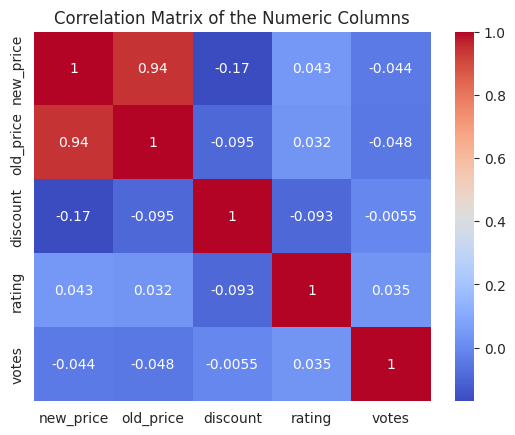

In [290]:
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of the Numeric Columns')

### Visualize top-rated products with at least 200 votes

In [291]:
# First filter for products with at least 200 votes (More votes makes a product rating more reliable)
products_with_atleast_200_votes_df = products_clean_df[products_clean_df['votes'] >= 200]
products_with_atleast_200_votes_df

,name,new_price,old_price,discount,rating,votes
0,NIVEA Perfect & Radiant Even Tone Day And Nigh...,899.0,1560.00,0.42,4.5,2218.0
1,NIVEA Radiant & Beauty Advanced Care Lotion Fo...,854.0,1460.00,0.42,4.7,612.0
2,NIVEA Nourishing Cocoa Body Lotion With Cocoa ...,1174.0,1302.00,0.10,4.7,1119.0
3,"NIVEA Pearl & Beauty Anti-Perspirant Rollon, 4...",728.0,1040.00,0.30,4.6,830.0
4,NIVEA MEN Deep Antibacterial Anti-Perspirant R...,655.0,1040.00,0.37,4.6,621.0
...,...,...,...,...,...,...
1489,Annov USB 64GB Flash Drive Metal +Earphone,588.0,629.00,0.15,3.9,406.0
1592,Rosy Toilet Paper Printed 10 Pack Wrapped,395.0,122.45,0.31,4.4,513.0
1635,Rosy Toilet Paper Printed 10 Pack Wrapped,395.0,122.45,0.31,4.4,513.0
1707,Ramtons RM/115 - 1.8L Auto Jug Kettle - White ...,2520.0,781.20,0.31,4.5,210.0


In [292]:
# Check counts of products with rating at least 4.5
top_rated_products_df = products_with_atleast_200_votes_df[products_with_atleast_200_votes_df['rating'] >= 4.5]
top_rated_products_df

,name,new_price,old_price,discount,rating,votes
0,NIVEA Perfect & Radiant Even Tone Day And Nigh...,899.0,1560.00,0.42,4.5,2218.0
1,NIVEA Radiant & Beauty Advanced Care Lotion Fo...,854.0,1460.00,0.42,4.7,612.0
2,NIVEA Nourishing Cocoa Body Lotion With Cocoa ...,1174.0,1302.00,0.10,4.7,1119.0
3,"NIVEA Pearl & Beauty Anti-Perspirant Rollon, 4...",728.0,1040.00,0.30,4.6,830.0
4,NIVEA MEN Deep Antibacterial Anti-Perspirant R...,655.0,1040.00,0.37,4.6,621.0
5,NIVEA Pearl & Beauty Black Pearl Fine Fragranc...,728.0,1040.00,0.30,4.7,219.0
9,NIVEA Q10 Power Anti-Wrinkle Day Cream 50ml & ...,2246.0,3840.00,0.42,4.6,416.0
90,Maybelline Fit Me Mattifying Primer Matte And ...,1120.0,1400.00,0.20,4.6,398.0
95,Qwen Aluminum Alloy Laptop Stand Computer Stand,650.0,1000.00,0.35,4.6,657.0
100,Garnier Skin Active Hydrabomb Pomegranate Tiss...,350.0,108.50,0.31,4.6,1503.0


In [293]:
# Selecting only votes & rating column before plotting
new_top_rated_products_df = top_rated_products_df[['name','rating', 'votes']].reset_index(drop=True)
new_top_rated_products_df

,name,rating,votes
0,NIVEA Perfect & Radiant Even Tone Day And Nigh...,4.5,2218.0
1,NIVEA Radiant & Beauty Advanced Care Lotion Fo...,4.7,612.0
2,NIVEA Nourishing Cocoa Body Lotion With Cocoa ...,4.7,1119.0
3,"NIVEA Pearl & Beauty Anti-Perspirant Rollon, 4...",4.6,830.0
4,NIVEA MEN Deep Antibacterial Anti-Perspirant R...,4.6,621.0
5,NIVEA Pearl & Beauty Black Pearl Fine Fragranc...,4.7,219.0
6,NIVEA Q10 Power Anti-Wrinkle Day Cream 50ml & ...,4.6,416.0
7,Maybelline Fit Me Mattifying Primer Matte And ...,4.6,398.0
8,Qwen Aluminum Alloy Laptop Stand Computer Stand,4.6,657.0
9,Garnier Skin Active Hydrabomb Pomegranate Tiss...,4.6,1503.0


Text(0.5, 0, 'Rating')

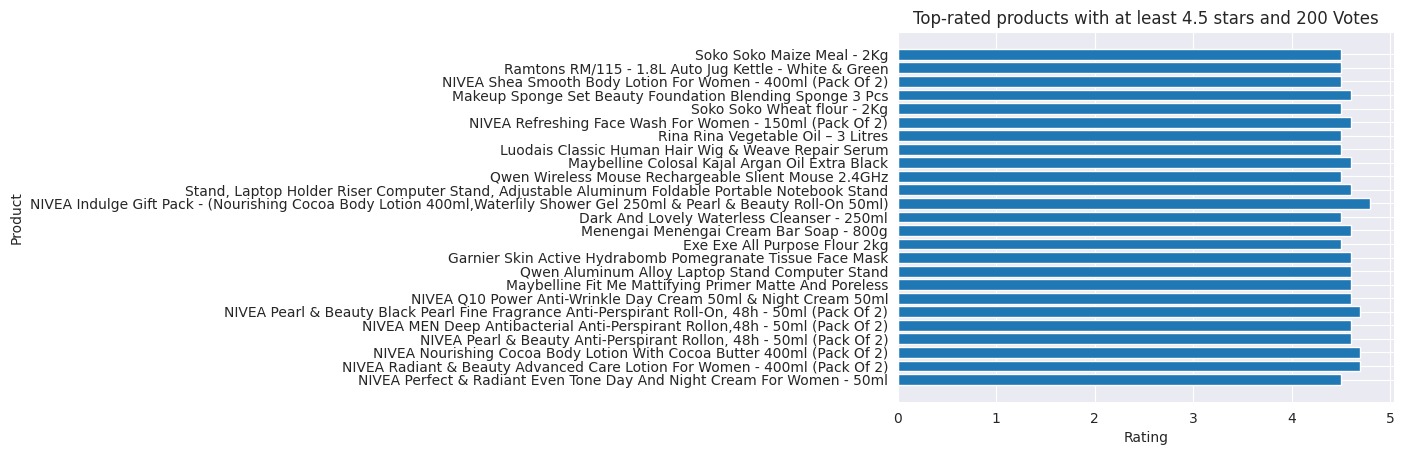

In [294]:
# Creating a horizontal bar plot
plt.barh(new_top_rated_products_df['name'], new_top_rated_products_df['rating'])

plt.title("Top-rated products with at least 4.5 stars and 200 Votes")
plt.ylabel("Product")
plt.xlabel("Rating")

### Showing product price distribution: Histogram with Kernel density estimate (kde) curve

Text(0.5, 1.0, 'Distribution of Product Prices')

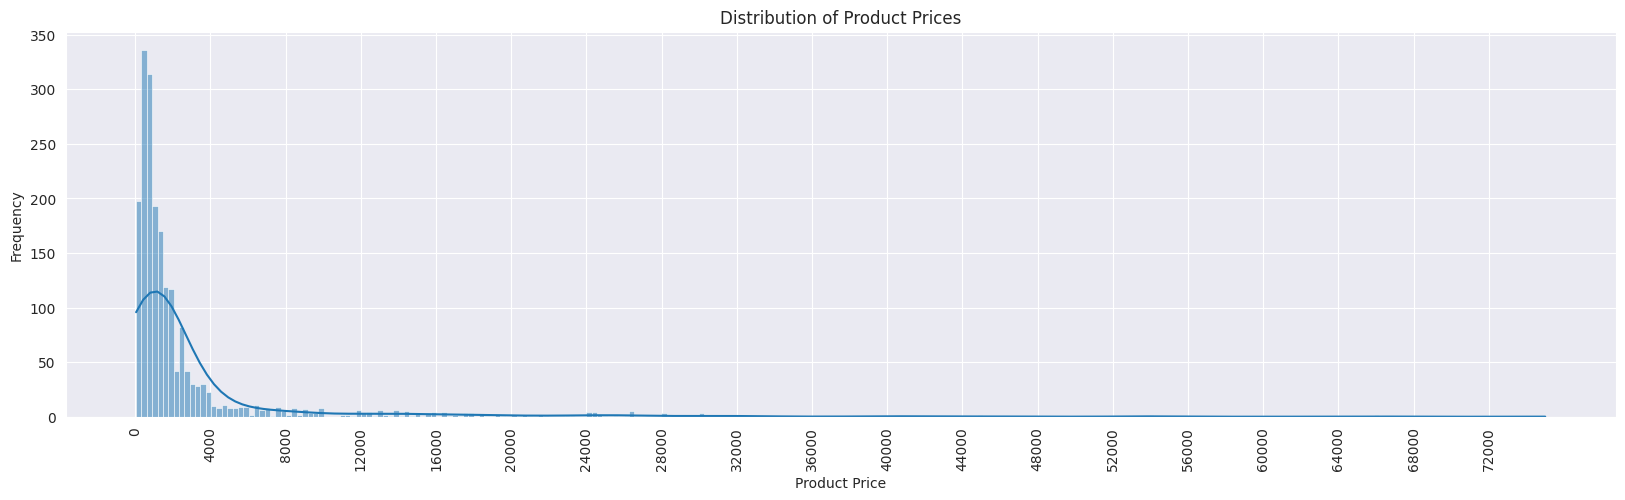

In [295]:
plt.figure(figsize=(20, 5))
sns.histplot(products_clean_df['new_price'], kde=True)
plt.xlabel('Product Price')
plt.xticks(np.arange(0, max(products_clean_df['new_price'])+1, 4000),rotation=90)
plt.ylabel('Frequency')
plt.title('Distribution of Product Prices')

### Visualizing discount distribution

Text(0.5, 1.0, 'Distribution of Discounts')

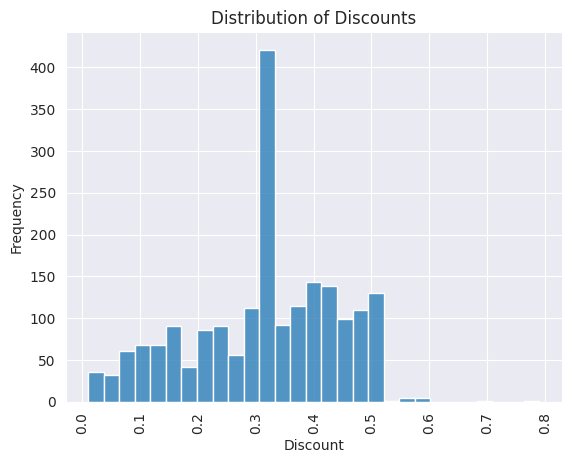

In [296]:
sns.histplot(products_clean_df['discount'])
plt.xlabel('Discount')
# plt.xticks(np.arange(0,max(products_clean_df['discount'])+1,0.5),rotation=90)
plt.xticks(rotation=90)
plt.ylabel('Frequency')
plt.title('Distribution of Discounts')

### Visualizing rating distribution

(array([  0.,  50., 100., 150., 200., 250., 300., 350.]),
 [Text(0, 0.0, '0'),
  Text(0, 50.0, '50'),
  Text(0, 100.0, '100'),
  Text(0, 150.0, '150'),
  Text(0, 200.0, '200'),
  Text(0, 250.0, '250'),
  Text(0, 300.0, '300'),
  Text(0, 350.0, '350')])

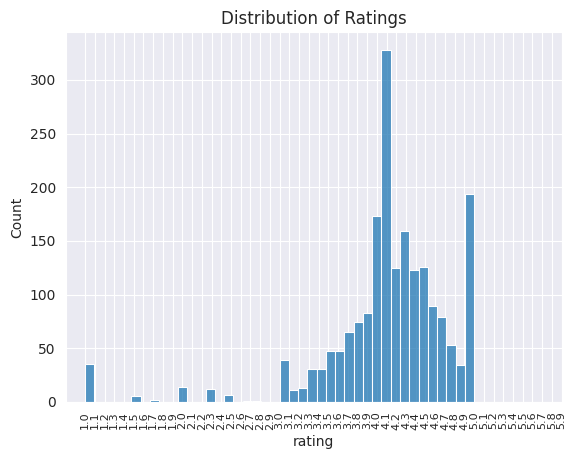

In [297]:
sns.histplot(data=products_clean_df, x='rating')
plt.title('Distribution of Ratings')
plt.xticks(np.arange(1.0, max(products_clean_df['rating'])+1, 0.1),rotation=90,fontsize=8)
plt.yticks()

### Visualizing relationship between rating and votes

Text(0.5, 1.0, 'Relationship between Votes and Rating')

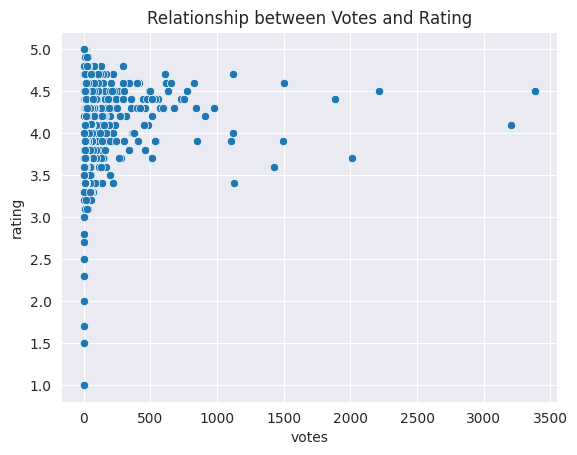

In [298]:
sns.scatterplot(data=products_clean_df, x='votes', y='rating')
plt.title('Relationship between Votes and Rating')

### Product Name Analysis

In [299]:
words = ' '.join(products_clean_df['name']).split()
all_words = Counter(words)
# len(all_words)  # 4580

# Returning an array of tuples with all_words & their counts, then return first 10
all_words_counts = all_words.most_common()
all_words_counts[:10]

[('Fashion', 458),
 ('-', 358),
 ('+', 197),
 ('With', 144),
 ('Black', 141),
 ('&', 129),
 ('For', 127),
 ('Shoes', 123),
 ("Men's", 103),
 ('And', 99)]

In [300]:
# Return only the alphabetical elements & their counts, & return the first 10
only_alpha_words_list = [(word, count) for word, count in all_words_counts if word.isalpha()]
only_alpha_words_list[:10]

[('Fashion', 458),
 ('With', 144),
 ('Black', 141),
 ('For', 127),
 ('Shoes', 123),
 ('And', 99),
 ('Wireless', 86),
 ('Smart', 82),
 ('Bluetooth', 78),
 ('Free', 72)]

In [301]:
# Select the top 30 words
first_30_words = only_alpha_words_list[:31]
first_30_words

# Future: Use library to remove conjuctions such as 'and' from this list

[('Fashion', 458),
 ('With', 144),
 ('Black', 141),
 ('For', 127),
 ('Shoes', 123),
 ('And', 99),
 ('Wireless', 86),
 ('Smart', 82),
 ('Bluetooth', 78),
 ('Free', 72),
 ('Men', 69),
 ('Women', 64),
 ('TV', 63),
 ('Hair', 63),
 ('Electric', 61),
 ('Set', 60),
 ('Casual', 59),
 ('Ladies', 58),
 ('Leather', 58),
 ('Power', 56),
 ('White', 55),
 ('Light', 55),
 ('Cable', 54),
 ('In', 51),
 ('Soft', 50),
 ('Cotton', 50),
 ('Mens', 49),
 ('Portable', 47),
 ('Solar', 47),
 ('Oil', 47),
 ('Watch', 45)]

Text(0.5, 1.0, 'Bar chart of Product Names & Values')

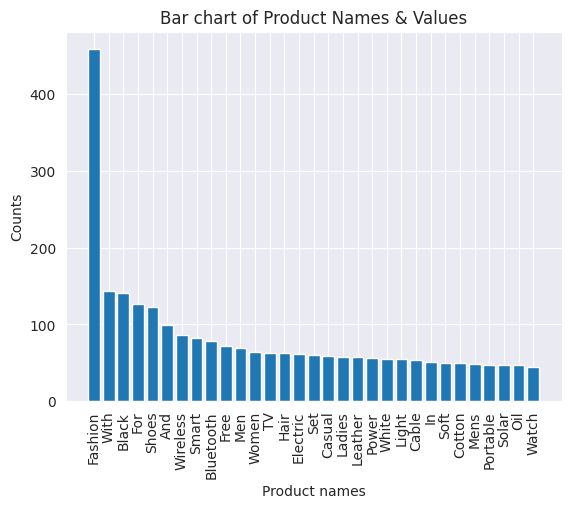

In [302]:
# Plot a chart with the first 30 words
plt.bar([d[0] for d in first_30_words], [d[1] for d in first_30_words])
plt.xlabel("Product names")
plt.xticks(rotation=90)
plt.ylabel("Counts")
plt.title("Bar chart of Product Names & Values")

### Creating pairplot showing relationship between various numerical columns

Text(0.5, 1.02, 'Pair Plot of Numerical Features')

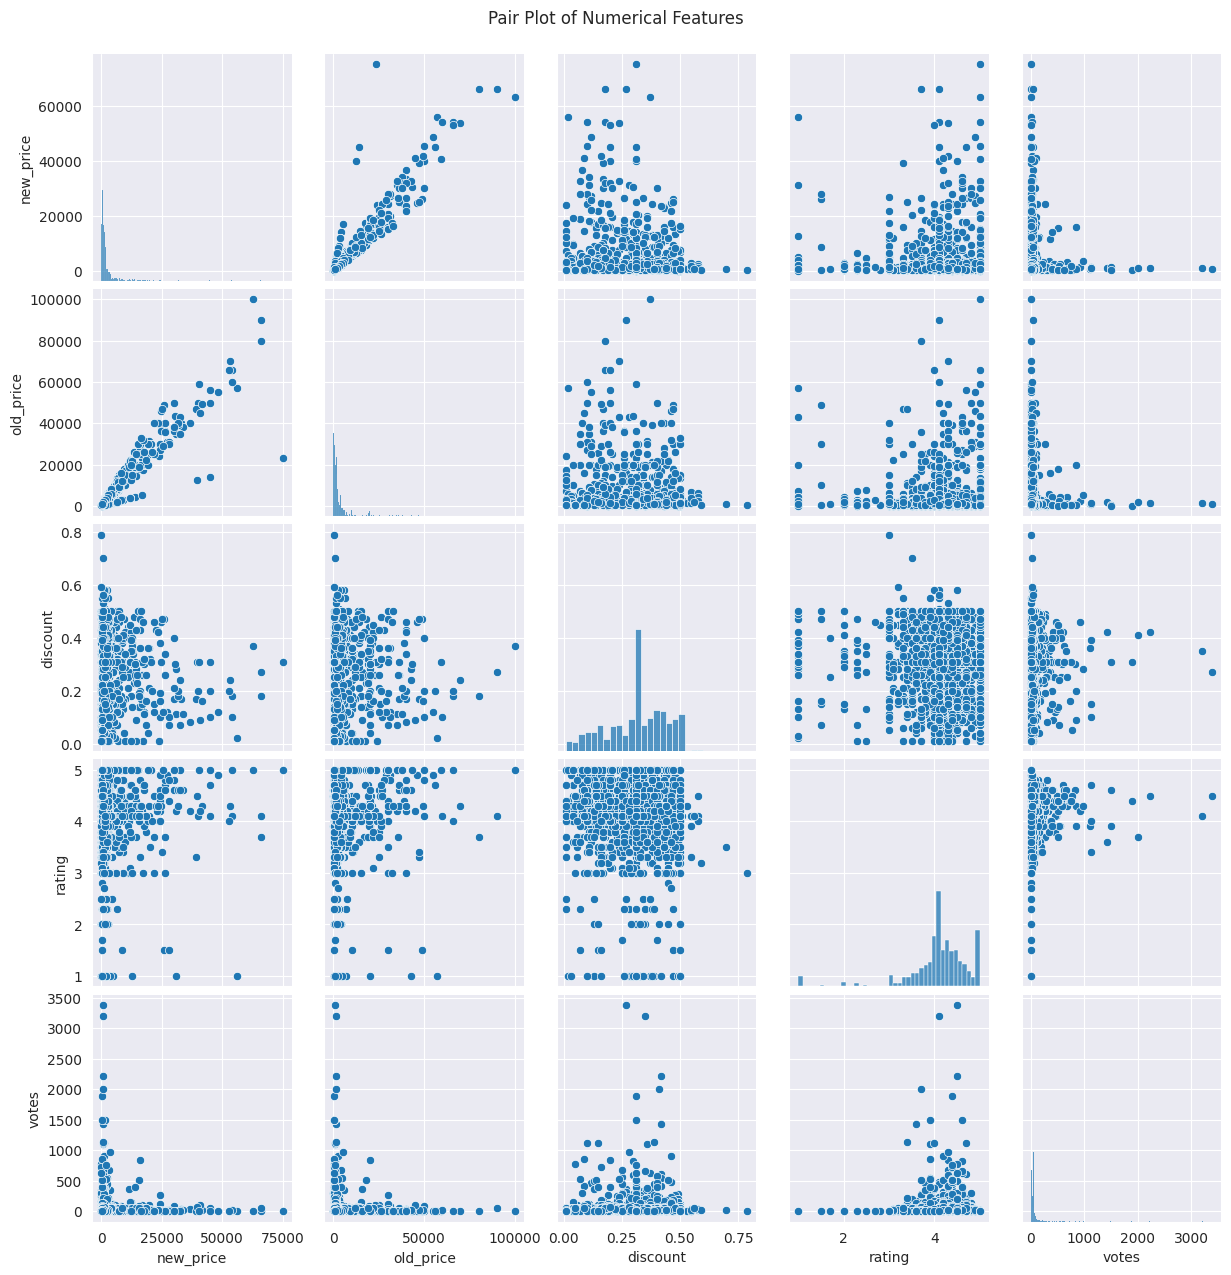

In [303]:
sns.pairplot(products_clean_df)
plt.suptitle('Pair Plot of Numerical Features', y=1.02)